## CODE

In [ ]:
"""
US UNEMPLOYMENT RATE FORECASTING
Complete time series analysis with multiple forecasting models

Required packages:
pip install numpy pandas matplotlib seaborn statsmodels scikit-learn tensorflow prophet deap mapie requests scipy
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')



# # Set matplotlib backend for interactive plots
# import matplotlib
# matplotlib.use('TkAgg')
# plt.ion()

# Suppress Prophet logging
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import breaks_hansen
from statsmodels.regression.linear_model import OLS

# ML libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Prophet
from prophet import Prophet

# Genetic Algorithm
from deap import base, creator, tools, algorithms

# Conformal Prediction
try:
    from mapie.regression import MapieRegressor
    from mapie.subsample import BlockBootstrap
    MAPIE_AVAILABLE = True
except ImportError:
    try:
        from mapie.regression import MapieRegressor
        MAPIE_AVAILABLE = True
        BlockBootstrap = None
    except ImportError:
        print("⚠ MAPIE not available. Conformal prediction will be skipped.")
        MAPIE_AVAILABLE = False
        MapieRegressor = None
        BlockBootstrap = None

# Additional libraries
import requests
from scipy import stats

print("=" * 80)
print("US UNEMPLOYMENT RATE FORECASTING - COMPLETE ANALYSIS")
print("=" * 80)

# ============================================================================
# 1. DATA RETRIEVAL
# ============================================================================


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# ============================================================================
# FETCH DATA FROM BLS API
# ============================================================================

import requests
import pandas as pd
mykey = 'ff7095746d954b8a884141069e4216e9'

url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"

payload = {
    "seriesid": ["LNS14000000"],      # Unemployment Rate (US)
    "startyear": "2005",
    "endyear": "2025",
    "registrationKey": mykey
}

r = requests.post(url, json=payload)

r.text
data = r.json()["Results"]["series"][0]["data"]
df = pd.DataFrame(data)




df["unemployment_rate"] = df["value"].astype(float)
df['year_month'] = df['year'] + '-' + df['period'].str[1:]
df['year_month'] = pd.to_datetime(df['year_month'])
        
df = df.sort_values('year_month').reset_index(drop=True)


Importing plotly failed. Interactive plots will not work.


US UNEMPLOYMENT RATE FORECASTING - COMPLETE ANALYSIS


In [4]:
# pip install matplotlib seaborn

# df['unemployment_rate'].quantile(np.arange(0, .8, 0.025))

df['unemployment_rate'].plot(title='US Unemployment Rate', ylabel='Unemployment Rate (%)')

<Axes: title={'center': 'US Unemployment Rate'}, ylabel='Unemployment Rate (%)'>

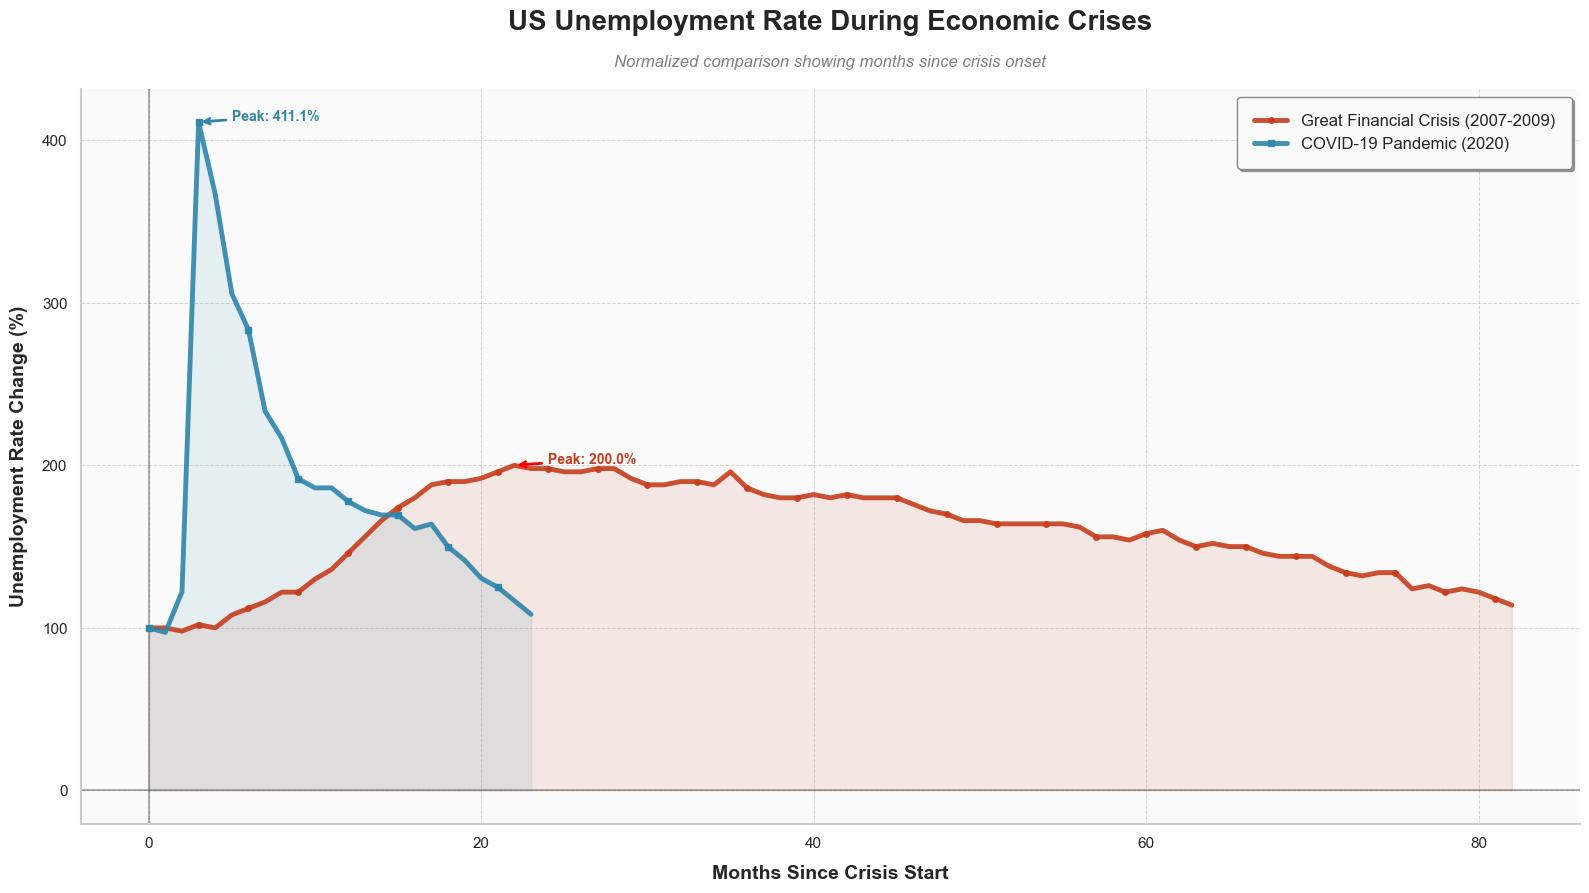

In [82]:
# #  ax.axvspan(pd.Timestamp('2007-12-01'), pd.Timestamp('2009-06-01'), 
# #                alpha=0.1, color='red', label='Great Recession')
# # ax.axvspan(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-04-01'), 

# df.columns           
           
df_crisis = pd.DataFrame({'Great Recession': df[df['year_month'].between('2007-12-01', '2014-10-01')]['unemployment_rate'].reset_index(drop=True),
                          'COVID-19 Pandemic': df['unemployment_rate'][df.index[df['year_month'].between('2020-01-01', '2021-12-31')]].reset_index(drop=True)})



df_crisis['GFC'] = df_crisis['Great Recession']/df_crisis['Great Recession'].iloc[0]
df_crisis['COVID-19'] = df_crisis['COVID-19 Pandemic']/df_crisis['COVID-19 Pandemic'].iloc[0]


# sns.lineplot(data=df_crisis[['GFC', 'COVID-19']]*100)
# plt.title('US Unemployment Rate During Crises (Normalized)')


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns


# Set modern style

matplotlib.use('Agg')  # Non-interactive backend


sns.set_style("whitegrid")
sns.set_palette("husl")

fig, ax = plt.subplots(figsize=(16, 9))

# Plot lines with markers
ax.plot(
    df_crisis.index, 
    df_crisis['GFC']*100, 
    linewidth=3.5, 
    color='#C73E1D', 
    label='Great Financial Crisis (2007-2009)',
    marker='o',
    markersize=4,
    markevery=3,
    alpha=0.9
)

ax.plot(
    df_crisis.index, 
    df_crisis['COVID-19']*100, 
    linewidth=3.5, 
    color='#2E86AB', 
    label='COVID-19 Pandemic (2020)',
    marker='s',
    markersize=4,
    markevery=3,
    alpha=0.9
)

# Title with subtitle
ax.text(
    0.5, 1.08, 
    'US Unemployment Rate During Economic Crises', 
    transform=ax.transAxes,
    fontsize=20, 
    fontweight='bold',
    ha='center'
)
ax.text(
    0.5, 1.03, 
    'Normalized comparison showing months since crisis onset', 
    transform=ax.transAxes,
    fontsize=12, 
    style='italic',
    ha='center',
    color='gray'
)

# Labels
ax.set_xlabel('Months Since Crisis Start', fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel('Unemployment Rate Change (%)', fontsize=14, fontweight='bold', labelpad=10)

# Legend with box
legend = ax.legend(
    loc='upper right',
    fontsize=12,
    framealpha=0.95,
    shadow=True,
    fancybox=True,
    borderpad=1
)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('gray')

# Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7, color='gray')
ax.set_axisbelow(True)

# Reference lines
ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.3, zorder=1)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5, alpha=0.3, zorder=1)

# Fill area under curves for emphasis
ax.fill_between(
    df_crisis.index, 
    0, 
    df_crisis['GFC']*100, 
    alpha=0.1, 
    color='#C73E1D'
)
ax.fill_between(
    df_crisis.index, 
    0, 
    df_crisis['COVID-19']*100, 
    alpha=0.1, 
    color='#2E86AB'
)

# Add peak annotations
gfc_max_idx = (df_crisis['GFC']*100).idxmax()
gfc_max_val = (df_crisis['GFC']*100).max()
ax.annotate(
    f'Peak: {gfc_max_val:.1f}%',
    xy=(gfc_max_idx, gfc_max_val),
    xytext=(gfc_max_idx+2, gfc_max_val+1),
    fontsize=10,
    fontweight='bold',
    color='#C73E1D',
    arrowprops=dict(arrowstyle='->', color='red', lw=2)
)

covid_max_idx = (df_crisis['COVID-19']*100).idxmax()
covid_max_val = (df_crisis['COVID-19']*100).max()
ax.annotate(
    f'Peak: {covid_max_val:.1f}%',
    xy=(covid_max_idx, covid_max_val),
    xytext=(covid_max_idx+2, covid_max_val+1),
    fontsize=10,
    fontweight='bold',
    color='#2E86AB',
    arrowprops=dict(arrowstyle='->', color='#2E86AB', lw=2)
)

# Styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Background
ax.set_facecolor('#FAFAFA')
fig.patch.set_facecolor('white')

# Tick styling
ax.tick_params(axis='both', which='major', labelsize=11, length=6, width=1.5)


%matplotlib inline
plt.tight_layout()
# plt.savefig('crisis_comparison_beautiful.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.close()

# plt.savefig(
#     r'C:\Users\Dell\data_science\rafaelcattan.github.io\analysis\crisis_comparison.png',
#     dpi=300,
#     bbox_inches='tight',
#     facecolor='white'
# )

# print('ok')

In [96]:
# df_crisis = pd.DataFrame({'Great Recession': df[df['year_month'].between('2007-12-01', '2014-10-01')]['unemployment_rate'].reset_index(drop=True),
#                           'COVID-19 Pandemic': df['unemployment_rate'][df.index[df['year_month'].between('2020-01-01', '2021-12-31')]].reset_index(drop=True)})



df[df['year_month'].between('2007-12-01', '2014-10-01')]['unemployment_rate'].shape[0]/12

6.916666666666667

In [97]:
df_crisis[~df_crisis['GFC'].isna()].max()

Great Recession      10.000000
COVID-19 Pandemic    14.800000
GFC                   2.000000
COVID-19              4.111111
dtype: float64

In [98]:
df['unemployment_rate'].std()/df['unemployment_rate'].mean()

0.3677046060400631

In [121]:

# NAIVE MASE CALCULATION WITH MEAN
naive_mase_numerator = sum(abs(df['unemployment_rate'] - df['unemployment_rate'].mean()))/len(df)
naive_mase_denominator = abs(df['unemployment_rate'] - df['unemployment_rate'].shift(1)).dropna().sum()/ (len(df)-1)

baseline = naive_mase_numerator / naive_mase_denominator


# NAIVE MASE CALCULATION WITH PAST 6 MONTHs
naive_mase_numerator_6m = sum(abs(df['unemployment_rate'] - df['unemployment_rate'].rolling(window=6).mean()).dropna())/len(df)
six_month_avg = naive_mase_numerator_6m / naive_mase_denominator


# NAIVA ARIMA(1,0,0) MASE
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df['unemployment_rate'], order=(1,0,0))
model_fit = model.fit()
arima_preds = model_fit.predict(start=1, end=len(df)-1)
naive_mase_numerator_arima = sum(abs(df['unemployment_rate'][1:] - arima_preds))/len(arima_preds)
arima_mase = naive_mase_numerator_arima / naive_mase_denominator    


baseline, six_month_avg, arima_mase

(8.878611111111093, 1.55625, 1.1373126616878917)